In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
BASE_DIR = "/home/fluentt/lightning-pflow"

In [32]:
import os
import rootutils

from hydra import initialize, compose
from hydra.utils import instantiate

os.chdir(BASE_DIR)
rootutils.setup_root(BASE_DIR, indicator=".project-root", pythonpath=True)

with initialize(version_base="1.3", config_path="../configs"):
    cfg = compose(config_name="train.yaml")
    print(cfg)

{'task_name': 'train', 'run_name': '???', 'tags': ['dev'], 'train': True, 'test': True, 'ckpt_path': None, 'transfer_ckpt_path': None, 'seed': 1234, 'data': {'_target_': 'pflow.data.text_mel_datamodule.TextMelDataModule', 'name': 'vctk', 'train_filelist_path': 'filelists/vctk_audio_sid_text_train_filelist_v0.92.txt', 'valid_filelist_path': 'filelists/vctk_audio_sid_text_val_filelist_v0.92.txt.cleaned', 'batch_size': 32, 'num_workers': 20, 'pin_memory': True, 'cleaners': ['english_cleaners2'], 'add_blank': True, 'n_spks': 109, 'n_fft': 1024, 'n_feats': 80, 'sample_rate': 22050, 'hop_length': 256, 'win_length': 1024, 'f_min': 0, 'f_max': 8000, 'data_statistics': {'mel_mean': -6.440719127655029, 'mel_std': 2.4679811000823975}, 'seed': '${seed}', 'min_sample_size': 4}, 'model': {'_target_': 'pflow.models.pflow_tts.pflowTTS', 'n_vocab': 178, 'n_spks': '${data.n_spks}', 'spk_emb_dim': 64, 'n_feats': 80, 'data_statistics': '${data.data_statistics}', 'out_size': None, 'prompt_size': 264, 'dur_

In [33]:
import datetime as dt
import math
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pflow import utils
from pflow.models.baselightningmodule import BaseLightningClass
from pflow.models.components.flow_matching import CFM
from pflow.models.components.speech_prompt_encoder import TextEncoder
from pflow.utils.model import (
    denormalize,
    duration_loss,
    fix_len_compatibility,
    generate_path,
    sequence_mask,
)
from pflow.models.components import commons
from pflow.utils.utils import plot_tensor

In [34]:
cfg.data.batch_size = 1
datamodule = instantiate(cfg.data)
datamodule.setup()
dl = datamodule.train_dataloader()
batch = next(iter(dl))
batch.keys()

dict_keys(['x', 'x_lengths', 'y', 'y_lengths', 'spks', 'wav', 'wav_lengths', 'prompt_spec', 'prompt_lengths'])

In [35]:
model = instantiate(cfg.model)
model

pflowTTS(
  (encoder): TextEncoder(
    (emb): Embedding(178, 192)
    (speech_prompt_proj): Conv1d(80, 192, kernel_size=(1,), stride=(1,))
    (prenet): ConvReluNorm(
      (conv_layers): ModuleList(
        (0-2): 3 x Conv1d(192, 192, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (norm_layers): ModuleList(
        (0-2): 3 x LayerNorm()
      )
      (relu_drop): Sequential(
        (0): ReLU()
        (1): Dropout(p=0, inplace=False)
      )
      (proj): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
    )
    (text_base_encoder): Encoder(
      (drop): Dropout(p=0.1, inplace=False)
      (attn_layers): ModuleList(
        (0-5): 6 x MultiHeadAttention(
          (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (query_rotary_pe): RotaryPositionalEmbeddings()
          (key_rotary_pe): RotaryPositionalEmbeddings()
  

In [36]:
# if you have pretrained model, load state dict
ckpt_path = "/home/fluentt/lightning-pflow/logs/train/multispeaker/runs/2024-04-15_07-11-18/checkpoints/last.ckpt"
model_state_dict = model.state_dict()
state_dict = torch.load(ckpt_path, map_location="cpu")['state_dict']
for k, v in model_state_dict.items():
    if k in state_dict and state_dict[k].size() == v.size():
        state_dict[k] = v
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

# 1. pflow model for Training

### 1-1. get_losses fn. in `pflow/models/baselightningmodule.py`

In [37]:

x, x_lengths = batch["x"], batch["x_lengths"]
y, y_lengths = batch["y"], batch["y_lengths"]
# prompt_spec = batch["prompt_spec"]
# prompt_lengths = batch["prompt_lengths"]
# prompt_slice, ids_slice = commons.rand_slice_segments(
#                 prompt_spec, 
#                 prompt_lengths, 
#                 self.prompt_size
#             )
prompt_slice = None
# dur_loss, prior_loss, diff_loss, attn = self(
#     x=x,
#     x_lengths=x_lengths,
#     y=y,
#     y_lengths=y_lengths,
#     prompt=prompt_slice,
# )

tensor([[  0,  61,   0, 156,   0,  87,   0, 158,   0,  44]])
torch.Size([1, 105]) torch.Size([1, 80, 396])


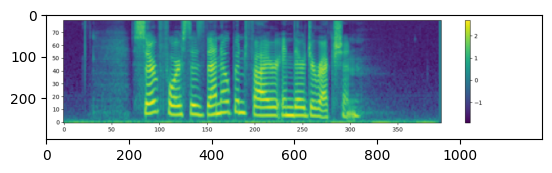

In [38]:
print(x[:,:10])
print(x.shape, y.shape)
plt.imshow(plot_tensor(y[0]))

### 1-2. forward fn. in `pflow/models/pflow_tts.py`

In [39]:
prompt_slice, ids_slice = commons.rand_slice_segments(
    y, y_lengths, model.prompt_size
)

torch.Size([1, 80, 264])
tensor([79])


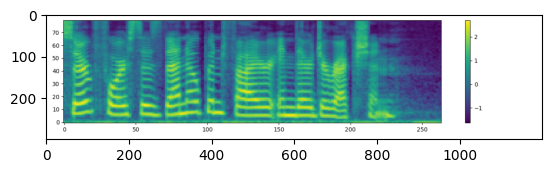

In [40]:
print(prompt_slice.shape) # number of mel frames (3s at 22050 SR; 3*22050//256)
print(ids_slice) 
plt.imshow(plot_tensor(prompt_slice[0]))

In [41]:
mu_x, logw, x_mask = model.encoder(x, x_lengths, prompt_slice)

torch.Size([1, 80, 105])
torch.Size([1, 1, 105])
torch.Size([1, 1, 105])


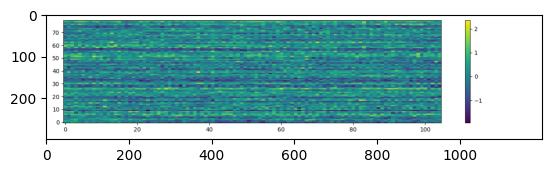

In [42]:
print(mu_x.shape)
print(logw.shape)
print(x_mask.shape)
plt.imshow(plot_tensor(mu_x[0].detach()))

tensor([[[ 0.3210, -1.2934, -0.5433, -0.9747, -0.3303,  0.1263, -0.2799,
           0.5417, -1.2184, -0.3424]]], grad_fn=<SliceBackward0>)


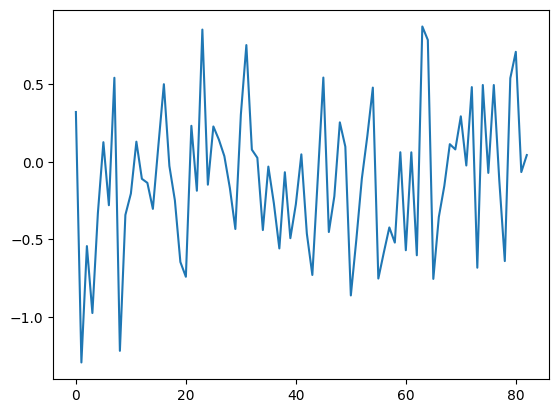

In [13]:
print(logw[:,:,:10])
plt.plot(logw[0,0,:].detach())

In [14]:
y_max_length = y.shape[-1]
y_max_length

348

In [15]:
x_mask

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [16]:
sequence_mask(y_lengths, y_max_length).unsqueeze(1).to(x_mask)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [17]:
y_mask = sequence_mask(y_lengths, y_max_length).unsqueeze(1).to(x_mask)
attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)

print(x_mask.shape, y_mask.shape, attn_mask.shape)

torch.Size([1, 1, 83]) torch.Size([1, 1, 348]) torch.Size([1, 1, 83, 348])


In [18]:
with torch.no_grad():
# negative cross-entropy
    s_p_sq_r = torch.ones_like(mu_x) # [b, d, t]
    # s_p_sq_r = torch.exp(-2 * logx) 
    neg_cent1 = torch.sum(
        -0.5 * math.log(2 * math.pi)- torch.zeros_like(mu_x), [1], keepdim=True
    )
    # neg_cent1 = torch.sum(
    #     -0.5 * math.log(2 * math.pi) - logx, [1], keepdim=True
    #     ) # [b, 1, t_s]
    neg_cent2 = torch.einsum("bdt, bds -> bts", -0.5 * (y**2), s_p_sq_r)
    neg_cent3 = torch.einsum("bdt, bds -> bts", y, (mu_x * s_p_sq_r))
    neg_cent4 = torch.sum(
        -0.5 * (mu_x**2) * s_p_sq_r, [1], keepdim=True
    )  
    neg_cent = neg_cent1 + neg_cent2 + neg_cent3 + neg_cent4
    
    attn_mask = torch.unsqueeze(x_mask, 2) * torch.unsqueeze(y_mask, -1)
    from pflow.utils.monotonic_align import maximum_path
    attn = (
        maximum_path(neg_cent, attn_mask.squeeze(1)).unsqueeze(1).detach()
    )

torch.Size([1, 1, 348, 83])


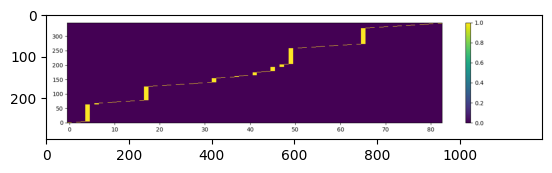

In [19]:
print(attn.shape)
plt.imshow(plot_tensor(attn[0][0].detach()))

In [20]:
logw_ = torch.log(1e-8 + attn.sum(2)) * x_mask
logw_, logw_.shape

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 4.0775, 0.0000, 1.3863, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 3.8501, 0.6931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           2.7081, 0.0000, 0.0000, 0.0000, 0.0000, 1.0986, 0.0000, 0.0000,
           0.0000, 2.3026, 0.0000, 0.0000, 0.6931, 2.6391, 0.0000, 2.0794,
           0.0000, 4.0073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 4.0073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000]]]),
 torch.Size([1, 1, 83]))

In [21]:
dur_loss = duration_loss(logw, logw_, x_lengths, use_log=model.dur_p_use_log)
dur_loss

tensor(143.4468, grad_fn=<DivBackward0>)

In [22]:
# Align encoded text with mel-spectrogram and get mu_y segment
attn = attn.squeeze(1).transpose(1,2)
mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
mu_y = mu_y.transpose(1, 2)

torch.Size([1, 80, 348])


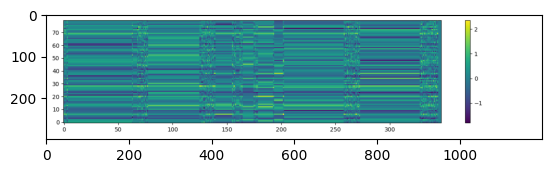

In [23]:
print(mu_y.shape)
plt.imshow(plot_tensor(mu_y[0].detach()))

In [24]:
y_loss_mask = sequence_mask(y_lengths, y_max_length).unsqueeze(1).to(x_mask)
for i in range(y.size(0)):
    y_loss_mask[i,:,ids_slice[i]:ids_slice[i] + model.prompt_size] = False

In [25]:
y_loss_mask

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [26]:
diff_loss, _ = model.decoder.compute_loss(x1=y.detach(), mask=y_mask, mu=mu_y, cond=None, loss_mask=y_loss_mask)
diff_loss

tensor(3.2539, grad_fn=<DivBackward0>)

In [27]:
prior_loss = torch.sum(0.5 * ((y - mu_y) ** 2 + math.log(2 * math.pi)) * y_loss_mask)
prior_loss = prior_loss / (torch.sum(y_loss_mask) * model.n_feats)
prior_loss

tensor(1.6687, grad_fn=<DivBackward0>)

# 2. Model components

### 2-1. forward fn. in TextEncoder `pflow/models/components/speech_prompt_encoder.py`
"""Run forward pass to the transformer based encoder and duration predictor

        Args:
            x (torch.Tensor): text input
                shape: (batch_size, max_text_length)
            x_lengths (torch.Tensor): text input lengths
                shape: (batch_size,)
            speech_prompt (torch.Tensor): speech prompt input

        Returns:
            mu (torch.Tensor): average output of the encoder
                shape: (batch_size, n_feats, max_text_length)
            logw (torch.Tensor): log duration predicted by the duration predictor
                shape: (batch_size, 1, max_text_length)
            x_mask (torch.Tensor): mask for the text input
                shape: (batch_size, 1, max_text_length)
        """

In [28]:
# mu_x, logw, x_mask = model.encoder(x, x_lengths, prompt_slice)
x_input = x
x_lengths = x_lengths
speech_prompt = prompt_slice

x_input.shape, x_lengths, speech_prompt.shape

(torch.Size([1, 83]), tensor([83]), torch.Size([1, 80, 264]))

In [29]:
x_emb = model.encoder.emb(x_input) * math.sqrt(model.encoder.n_channels)
print(x_emb.shape)
x_emb = torch.transpose(x_emb, 1, -1)
print(x_emb.shape)
x_emb_mask = torch.unsqueeze(sequence_mask(x_lengths, x_emb.size(2)), 1).to(x_emb.dtype)
x_emb = model.encoder.text_pos_emb(x_emb.unsqueeze(1).transpose(-2,-1)).squeeze(1).transpose(-2,-1)
print(x_emb.shape)
x_emb = model.encoder.text_base_encoder(x_emb, x_emb_mask)
print(x_emb.shape)

torch.Size([1, 83, 192])
torch.Size([1, 192, 83])
torch.Size([1, 192, 83])
torch.Size([1, 192, 83])


In [ ]:
x_speech_lengths = x_lengths + speech_prompt.size(2)
speech_lengths = x_speech_lengths - x_lengths
speech_mask = torch.unsqueeze(sequence_mask(speech_lengths, speech_prompt.size(2)), 1).to(x_emb.dtype)